In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import NetworkOptimizer, fast_evaluator, density_distance
import seaborn as sns

In [57]:
def evaluate_adjacency(empirical_adj, simulated_adj):
    """
    Compute Accuracy and F1 score between two binary adjacency matrices.
    
    Args:
        empirical_adj (np.ndarray): Empirical adjacency (0/1), shape (n, n)
        simulated_adj (np.ndarray): Simulated adjacency (0/1), shape (n, n)
    
    Returns:
        (accuracy, f1): Tuple of floats
            - accuracy is in [0, 100] (percentage)
            - f1 is in [0, 1]
    """
    # Ensure inputs are numpy arrays and flattened (if we want to ignore diagonal, filter it out)
    # Here, we keep the entire matrix as is, including diagonal if present.
    A_emp = empirical_adj.astype(int).ravel()
    A_sim = simulated_adj.astype(int).ravel()

    # Calculate confusion matrix components:
    TP = np.sum((A_emp == 1) & (A_sim == 1))
    FP = np.sum((A_emp == 0) & (A_sim == 1))
    TN = np.sum((A_emp == 0) & (A_sim == 0))
    FN = np.sum((A_emp == 1) & (A_sim == 0))

    # Accuracy (percentage)
    total = TP + FP + TN + FN
    accuracy = 100.0 * (TP + TN) / total if total > 0 else 0.0

    # Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    # F1 Score (in [0, 1])
    if (precision + recall) > 0:
        f1 = 2.0 * precision * recall / (precision + recall)
    else:
        f1 = 0.0

    return accuracy, f1

In [3]:
res_parcellation = 1
consensus_mat = scipy.io.loadmat(
    "datasets/human/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

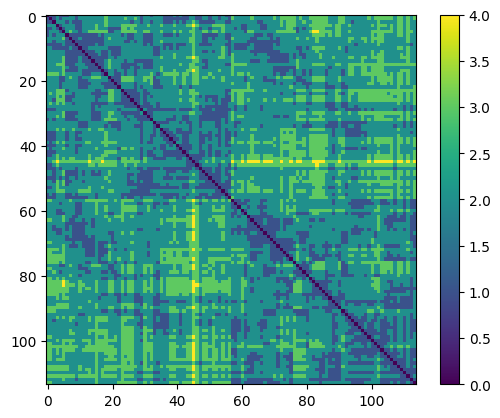

In [4]:
plt.imshow(gen.shortest_path_distance(connectivity, coordinates))
plt.colorbar()

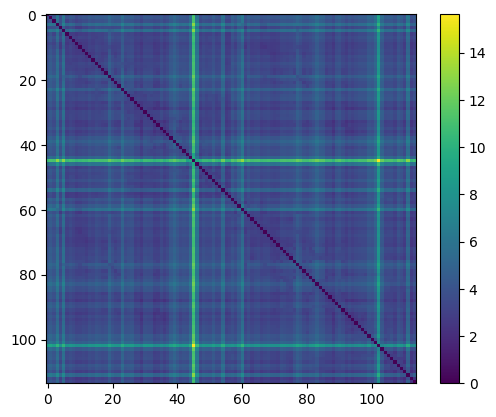

In [5]:
plt.imshow(gen.resistance_distance(connectivity, coordinates))
plt.colorbar()

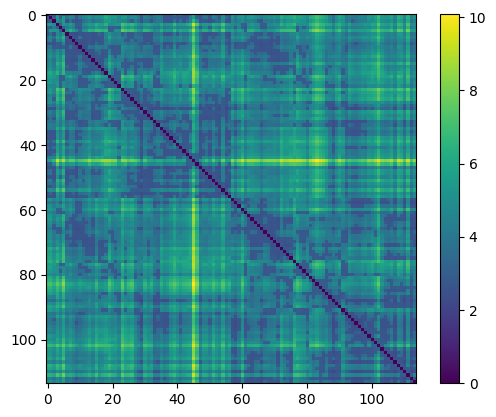

In [6]:
plt.imshow(gen.propagation_distance(connectivity, coordinates))
plt.colorbar()

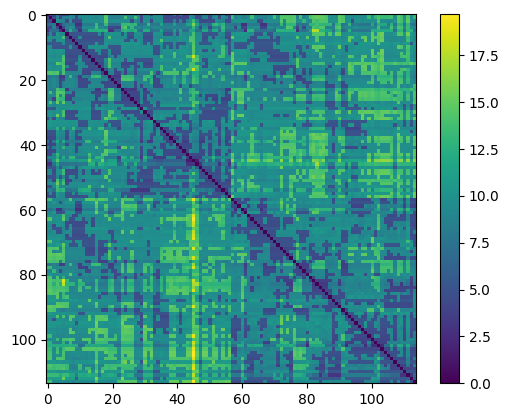

In [7]:
plt.imshow(gen.search_information(connectivity, coordinates))
plt.colorbar()

In [29]:
optimizer = NetworkOptimizer(
    simulation_model=gen.simulate_network_evolution,
    evaluation_function=density_distance,
    param_ranges={
        'alpha': (0.01, 2),
        'beta': (0.01, 2),
    },
    random_seed=11,
    sim_kwargs={
        'coordinates': coordinates,
        'n_iterations': 2500,
        'distance_fn': gen.resistance_distance,
        'noise': np.zeros(2500),
        'connectivity_penalty': np.zeros(2500),
        'batch_size': np.full(2500, 8),
    },
    eval_kwargs={
        'empirical': connectivity
    }
)

# Run optimization
results = optimizer.optimize(
    n_calls=20,
    n_parallel_samples=1,
    acquisition_function='EI',
)

Running Bayesian optimization...


Simulating network evolution: 100%|██████████| 2499/2499 [00:33<00:00, 73.52it/s]


In [30]:
results.best_parameters

{'alpha': 1.998836605168738, 'beta': 0.3401204170010752}

In [31]:
results.best_score

0.03262542320714065

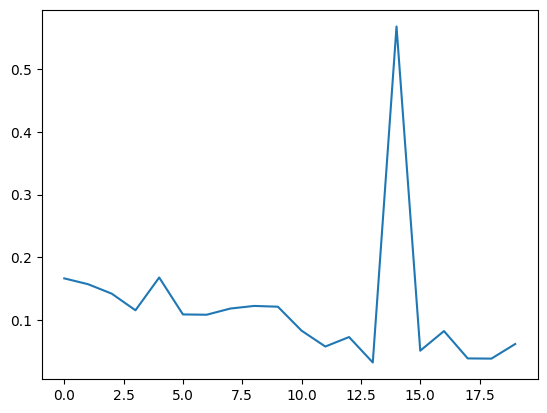

In [32]:
plt.plot(results.all_scores)

In [70]:
# Create parameter trajectories
n_iterations = 2500
n_nodes = connectivity.shape[0]
alpha = np.full(n_iterations, 0.1)
beta = np.full(n_iterations, 0.01)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)
batch_size = np.full(n_iterations, 8)

# Run simulation
history2 = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    alpha=alpha,
    beta=beta,
    noise=noise,
    distance_fn=gen.resistance_distance,
    connectivity_penalty=penalty,
    n_jobs=-1,  # Use all available cores
    random_seed=100,
    batch_size=batch_size,
)

Simulating network evolution: 100%|██████████| 2499/2499 [00:41<00:00, 60.21it/s]


In [ ]:
# there's stochasticity in the simulation, 
# so we need to run it multiple times and that can give us weights.

In [71]:
np.sum(history2[:,:,-1])/(connectivity.shape[0])**2

0.2146814404432133

In [35]:
np.sum(connectivity)/(connectivity.shape[0])**2

0.20098491843644198

In [60]:
(np.sum(history[:,:,-1])/(connectivity.shape[0])**2) - (np.sum(connectivity)/(connectivity.shape[0])**2)

0.01385041551246538

In [59]:
evaluate_adjacency(connectivity, history[:,:,-1])

(80.24007386888273, 0.5247964470762398)

In [38]:
0.20 - 0.168

0.032

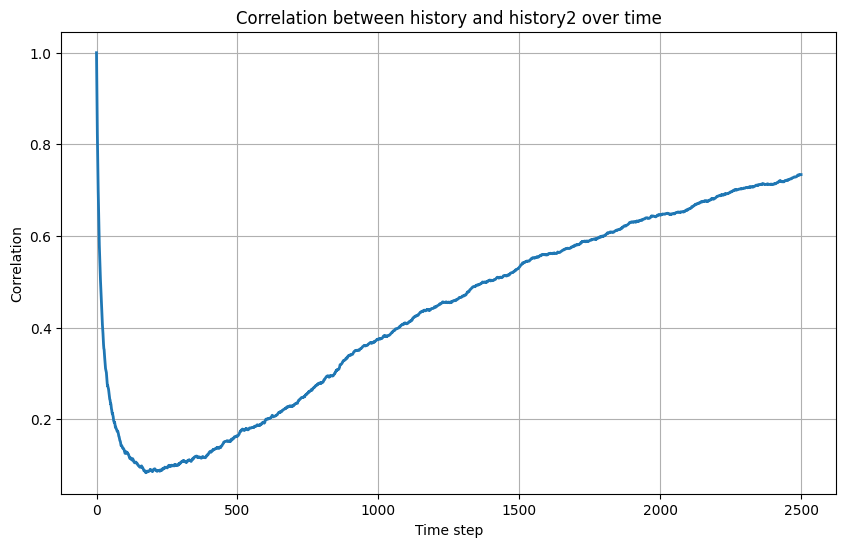

In [72]:
# Calculate correlation for each time point
correlations = []
for t in range(history.shape[2]):
    # Flatten the matrices at time t for correlation
    h1_flat = history[:,:,t].flatten()
    h2_flat = history2[:,:,t].flatten()
    # Calculate correlation
    corr = np.corrcoef(h1_flat, h2_flat)[0,1]
    correlations.append(corr)

# Plot correlation over time
plt.figure(figsize=(10, 6))
plt.plot(correlations, lw=2)
plt.xlabel('Time step')
plt.ylabel('Correlation')
plt.title('Correlation between history and history2 over time')
plt.grid(True)

In [73]:
evaluate_adjacency(history[:,:,-1], history2[:,:,-1])

(91.02800861803632, 0.7911142959512719)

In [61]:
# Vectorized correlation computation
flattened_history = history.reshape(history.shape[0] * history.shape[1], history.shape[2])
corr_matrix = np.corrcoef(flattened_history.T)


<Axes: >

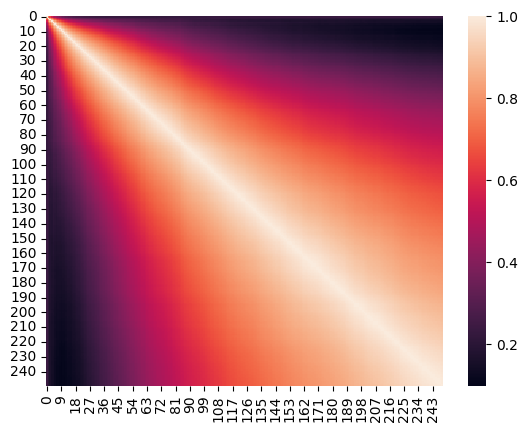

In [62]:
sns.heatmap(corr_matrix[::10,::10],vmin=corr_matrix.min(),vmax=1)

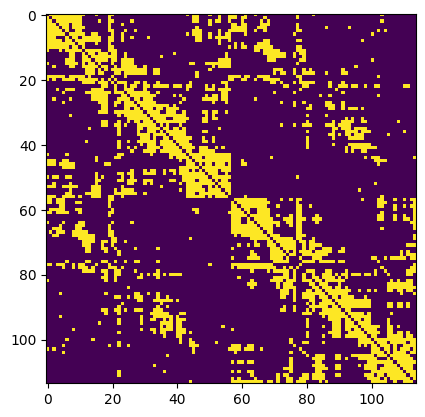

In [67]:
plt.imshow(history2[:,:,-1])

In [68]:
evaluate_adjacency(history[:,:,-1], history2[:,:,-1])

(91.2280701754386, 0.7951114306254493)

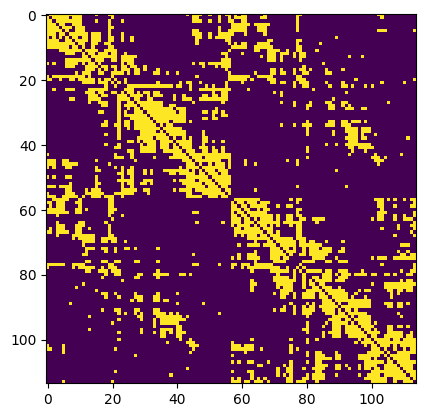

In [63]:
plt.imshow(history[:,:,-1])

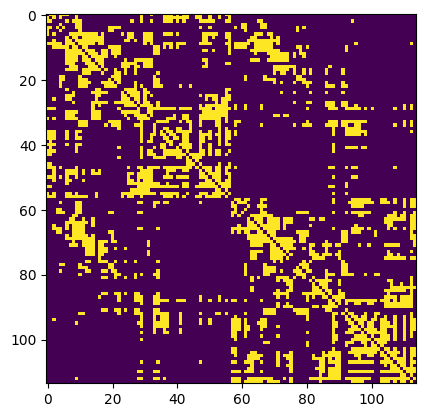

In [42]:
plt.imshow(connectivity)

In [43]:
energy_vector = np.zeros(history.shape[2])
clustering_vector = np.zeros(history.shape[2])
betweenness_vector = np.zeros(history.shape[2])
distance_vector = np.zeros(history.shape[2])
degrees_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(history[:,:,t], connectivity, euclidean_dis)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

Evaluating network evolution: 100%|██████████| 2500/2500 [00:37<00:00, 66.69it/s]


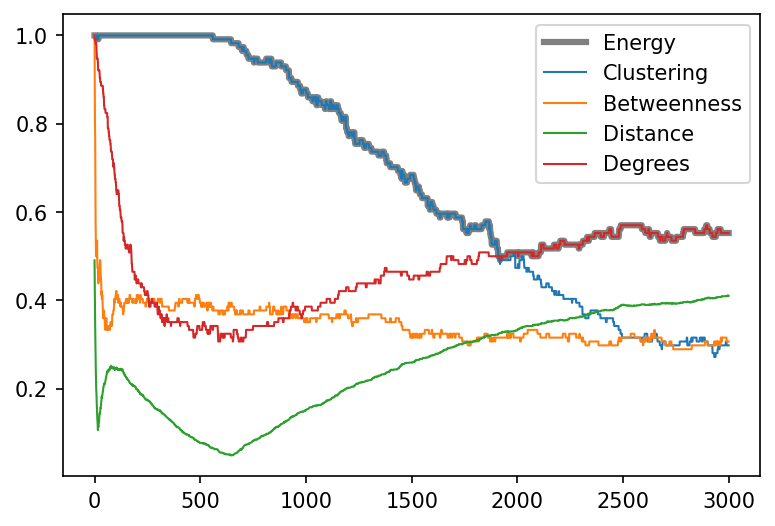

In [20]:
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(energy_vector,lw=3,label='Energy',color='gray')
plt.plot(clustering_vector,lw=1,label='Clustering')
plt.plot(betweenness_vector,lw=1,label='Betweenness')
plt.plot(distance_vector,lw=1,label='Distance')
plt.plot(degrees_vector,lw=1,label='Degrees')
plt.legend();

In [44]:
np.min(energy_vector)

0.38596491228070173

In [45]:
np.argmin(energy_vector)

2119

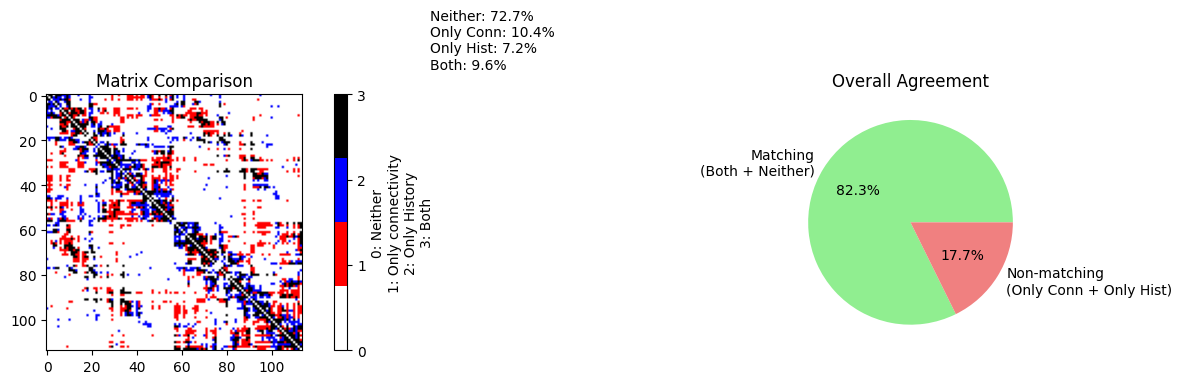

In [46]:
# Create a figure
plt.figure(figsize=(15, 4))

# Get the time point with minimum energy
#min_energy_point = energy_vector.argmin()
min_energy_point = n_iterations - 1

# Create subplots
plt.subplot(121)
# Create a custom matrix where:
# 0: neither (white)
# 1: only connectivity (red)
# 2: only history (blue)
# 3: both (black)
comparison = connectivity.astype(int) + 2 * history[:,:,min_energy_point].astype(int)
plt.imshow(comparison, cmap=plt.cm.colors.ListedColormap(['white', 'red', 'blue', 'black']))
plt.title('Matrix Comparison')
plt.colorbar(ticks=[0, 1, 2, 3], 
            label='0: Neither\n1: Only connectivity\n2: Only History\n3: Both')

# Add percentage text
total = connectivity.shape[0] * connectivity.shape[1]
neither = np.sum(comparison == 0) / total * 100
only_conn = np.sum(comparison == 1) / total * 100
only_hist = np.sum(comparison == 2) / total * 100
both = np.sum(comparison == 3) / total * 100

plt.text(1.5, 1.1, f'Neither: {neither:.1f}%\nOnly Conn: {only_conn:.1f}%\n'
         f'Only Hist: {only_hist:.1f}%\nBoth: {both:.1f}%', 
         transform=plt.gca().transAxes)

# Add second subplot for overlap percentage
plt.subplot(122)
labels = ['Matching\n(Both + Neither)', 'Non-matching\n(Only Conn + Only Hist)']
values = [(both + neither), (only_conn + only_hist)]
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Overall Agreement')

plt.tight_layout()

Evaluating network evolution:   0%|          | 0/2500 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 2500/2500 [00:02<00:00, 875.83it/s]


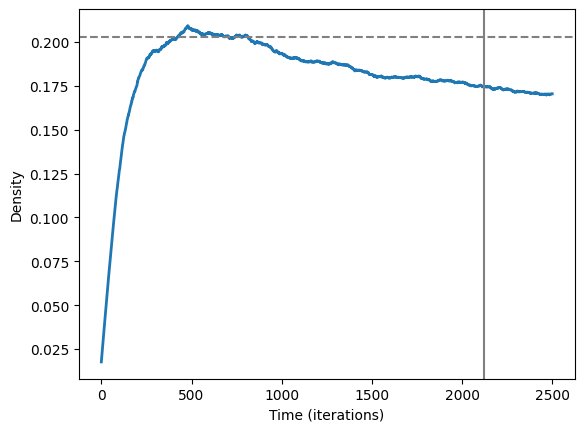

In [47]:
density = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(history[:,:,t]))

plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(connectivity))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(energy_vector), color='gray', linestyle='-')


In [88]:
import seaborn as sns

In [89]:
history[:,:,-1].astype(int).shape

(242, 242)

In [90]:
data.astype(int).shape

(242, 242)

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_3392/1531759925.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


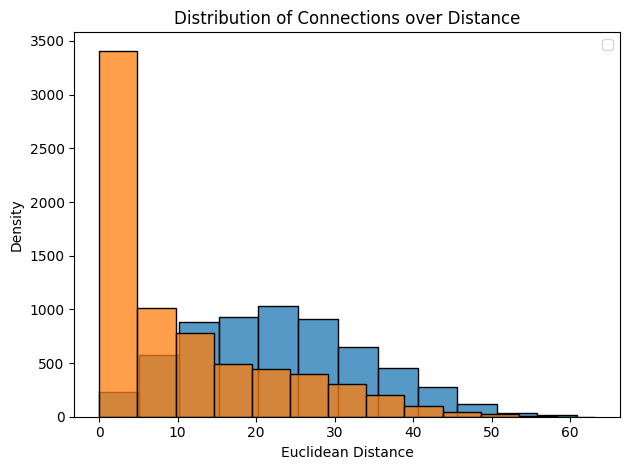

In [270]:
sns.histplot(macaque_euclidean_dist[data],binwidth=5)
what = history[:,:,-1].astype(bool)
sns.histplot(macaque_euclidean_dist[what],binwidth=5)

plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.title('Distribution of Connections over Distance')
plt.legend()

plt.tight_layout()

In [95]:
what

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [96]:
connectivity

array([[False,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False]])